# **Google Trends about the Crisis in Bangladesh**

In [28]:
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime as dt
import geopandas as gpd

from googleapiclient.discovery import build
from googleapiclient.http import HttpError

from credentials import get_key

We ensure API connection

The general purpose of this code is to provide a Google class that acts as a wrapper to interact with the Google API, specifically designed to perform authentication and GET requests to the Google Trends service. It allows accessing API methods, such as **getGraph** and **getTimelinesForHealth**, processing the data obtained in JSON format, converting them into a DataFrame with the **pandas** library and exporting them as CSV files for easy analysis. In addition, it includes functionalities to handle authentication through an API token and encapsulates the API interaction logic to simplify its use in custom applications.

In [ ]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
class Google():
    """
    Wrapper class for handling authentication and requests (GET) to Google API

    Parameters
    ----------
    token : str
        Google API token

    Notes
    -----
    For more information, please see https://developers.google.com/apis-explorer
    """
    def __init__(self, token=None):
        self.TOKEN = token if token else os.getenv("GOOGLE_API_KEY")
        self._service = None

    @property
    def service(self):
        """Authenticate and instantiate Google API service"""
        return build('trends', 'v1beta', static_discovery=False, developerKey=self.TOKEN)

    def get(self, method, params):
        """Get result from Google API method"""
        return getattr(self.service, method)(**params).execute()


    def download(self, method, params):
        """Download result from Google API method"""

        if not method in ["getGraph", "getTimelinesForHealth"]:
            raise NotImplementedError("Method not supported.")

        result = self.get(method, params)

        df = pd.json_normalize(result["lines"], meta=["term"], record_path=["points"])

        params = "+".join([f"{k}={v}" for k, v in params.items()])
        name = f"{method}+{params}.csv"

        df.to_csv(name, index=False)

In [48]:
google = Google(get_key())

For the purpose of this analysis, we’ve broken down search terms into six major categories. These categories broadly caputre people’s interest over time and provides high level insights into their behavior. These categories include:

*   Exchange Rate
*   Devaluation
*   Prices
*   Natural Disasters
*   Conflicts
*   Other relevant terms

These terms have been collected from Google’s related terms and topics search, as well as brainstorming with the team.

## Topic based search

In [49]:
forex_terms = {"Exchange Rate": ["bangladeshi immigration", 'bangladeshi birr', "bangladeshi black market", "National Bank of Bangladesh",
               "Central Bank of Bangladesh", "BRAC Bank exchange rate",
            "Dutch-Bangla Bank Limited exchange rate", "national bank of bangladesh exchange rate", "gold price in bangladesh"]}

deval_terms = {"Devaluation" : ["GDP per capita", "inflation rate "]}

price_terms = {"Prices" : ["fuel price in bangladesh", "fuel price", "gasoline price", "gold price", "gold price in bangladesh",
               "silver price in bangladesh"]}

disaster_terms = {"Natural Disasters" : ["earthquake", "landslides", "floods"]}

conflict_terms = {
    "Conflict": [
        "Sheikh Hasina",         
        "student protest", 
        "bangladesh quota protest",       
        "violence in bangladesh",    
        "labor strikes Bangladesh",        
    ]
}

other_terms = {"The urban redevelopment plan" : ["Old Dhaka"]}  

In [50]:
df = pd.DataFrame()

for dicts in [forex_terms, deval_terms, price_terms, disaster_terms, conflict_terms, other_terms]:

    for topic, lis in dicts.items():
        for term in lis:
            filters = {
                        'terms': term,
                        'restrictions_geo': "BD", 
                        'restrictions_startDate': "2024-01", 
                        'restrictions_endDate' : "2024-10" 
                    }

            r = google.get('getGraph', filters)

            df_ = pd.DataFrame(r['lines'][0]['points'])
            df_['term'] = term
            df_['topic'] = topic

            df = pd.concat([df, df_])

In [51]:
def get_topic_charts(df, topic):
    """"
    Function to create plots for a selected topic

    Inputs:
    df : pandas dataframe with Google's data from API
    tpoic : topic to plot data for

    Returns
    None
    """

    dftemp = df.query(f"topic == '{topic}'")
    dftemp.date = dftemp.date.apply(pd.to_datetime)
    dftemp = dftemp.pivot(index = 'date', columns = 'term', values = 'value')

    for cols in dftemp.columns:
        if len(dftemp[cols].unique()) == 1:
            del dftemp[cols]


    fig, ax = plt.subplots(1, 1)
    dftemp.plot(ax = ax, figsize = (15, 8))
    if topic == "Conflict":
        ax.axvline(pd.Timestamp('2024-08-05'),color='r', ls = '-.', lw = 2, label = "Uncontrolled protests") #Estas etiquetas corresponden para el caso de Etipia. CAMBIAR
    elif topic == "Natural Disasters":
        pass
    else:
        ax.axvline(pd.Timestamp('2024-08-05'),color='r', ls = '-.', lw = 2, label = "Uncontrolled protests") # Ajustado al caso de Bangladesh
    plt.legend()
    plt.ylabel("Normalized search score", fontsize = 10);
    plt.xlabel('')
    ax.set_title(f"Relative Google Search Trends for {topic} related terms", fontsize = 12);

This section uses the data gatehred from Google’s API and creates charts to see the trends for each of the search terms. In cases where its relevant, the benchmarking lines are shown for when FX market liberalization was annnounced and when Somaliland agreed to lease land to Ethiopia to build a naval facility.

For the topics **Exchange rate**, **Devaluation** and **Prices** - we can see sharp increase in the search for July 28th 2024, which was the date when market liberalization news first came out. People were inersted in knowing the more about devaluation and what it meant for the economy.

The graph represents the normalized search volume for each term over time. A higher search score indicates an increase in the number of Google searches for that specific term.

**Key insights from the graph:**

**Search Spikes:** Significant search activity is observed for terms like "BRAC Bank exchange rate," "Central Bank of Bangladesh," and "Bangladeshi immigration" around the middle of the year.

**Protests:** The term "Uncontrolled protests" shows a notable surge in searches around early August, coinciding with the vertical red line in the chart, possibly reflecting a specific event.

**Volatility:** The search trends for most terms are characterized by sharp fluctuations, with noticeable rises and declines throughout the year.

**Stability:** "Gold price in Bangladesh" and "National Bank of Bangladesh" exhibit relatively steady and lower search volumes compared to other terms, indicating less variation in public interest.

C:\Users\ronco\AppData\Local\Temp\ipykernel_18844\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


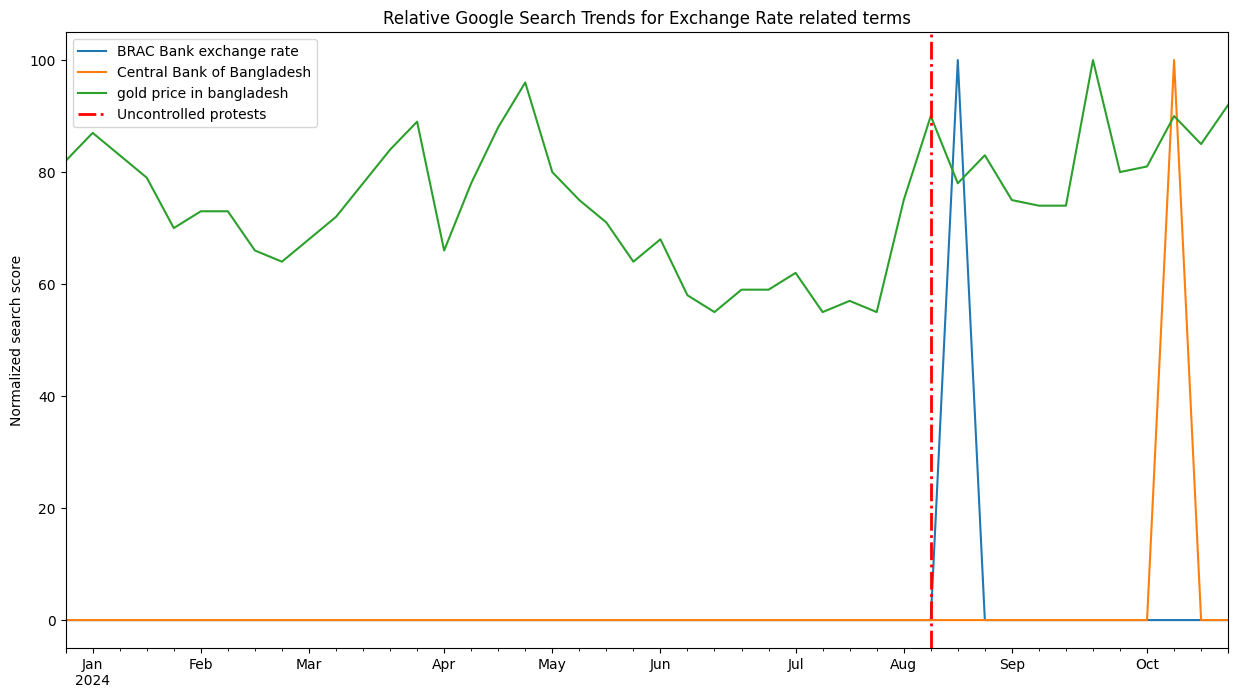

In [52]:
get_topic_charts(df, "Exchange Rate")

This graph provides insight into how Google searches around devaluation-related topics in Bangladesh fluctuated throughout 2024. The volatility across all three terms suggests significant economic and political developments impacting the country during this period.

**Key observations:**

* The GDP per capita and inflation rate trends show significant volatility throughout the year, with sharp spikes and drops in search activity.

* The "Uncontrolled protests" term also exhibits high volatility, with a massive spike in search volume around mid-July.

* The GDP per capita and inflation rate searches appear to be closely correlated, suggesting the public is searching for information on the economic situation and its impact.

* The large spike in "Uncontrolled protests" coincides with a dip in the GDP per capita and inflation rate searches, possibly indicating public unrest related to economic conditions.

C:\Users\ronco\AppData\Local\Temp\ipykernel_18844\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


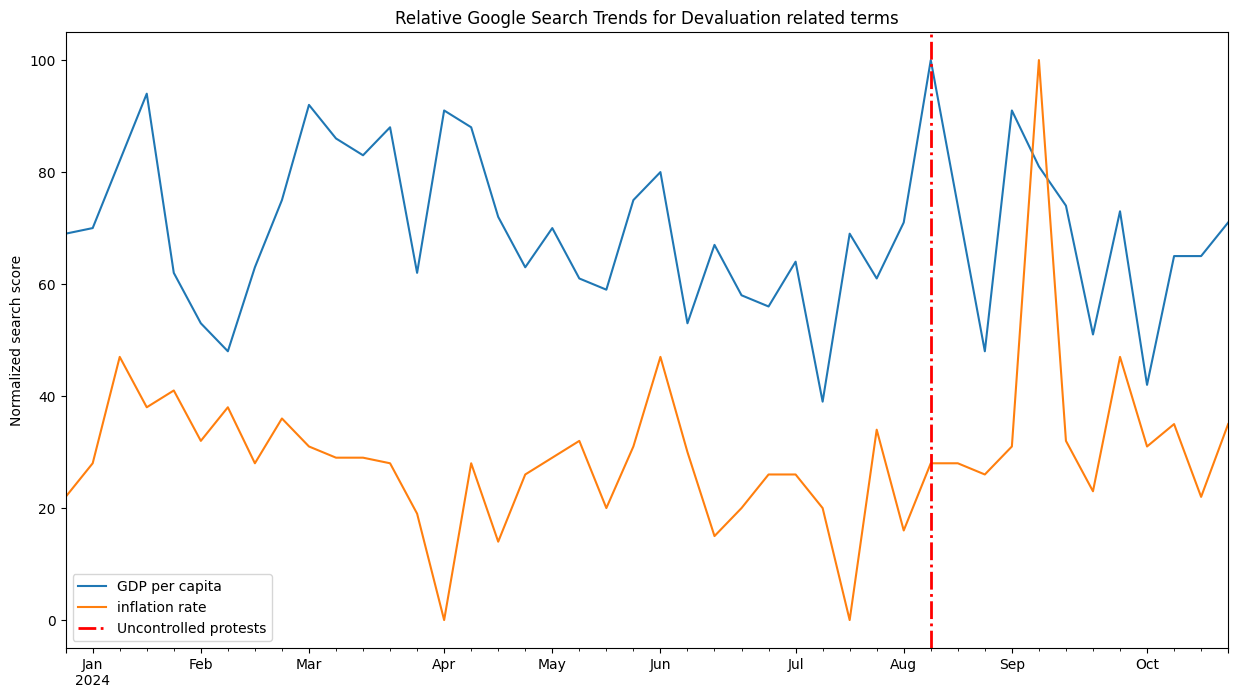

In [53]:
get_topic_charts(df, "Devaluation")

The fluctuations seen in these price-related terms suggest that Bangladesh likely faced significant economic events or disruptions affecting the cost of living during this period. The spike in searches for "Uncontrolled protests" could reflect public unrest or reactions to these price changes.

**Key observations:**

* The search trends for fuel prices, both globally and in Bangladesh, show considerable volatility throughout the year, with several sharp increases and decreases.

* The prices of gold (globally and in Bangladesh) and silver in Bangladesh also demonstrate notable fluctuations, with large shifts in public search interest.

* The term "Uncontrolled protests" shows a significant rise in search activity around mid-July, which coincides with some of the volatility in price-related terms.

* Overall, the graph suggests that major developments and changes in fuel, precious metals, and other prices in Bangladesh throughout 2024 generated substantial public interest and search activity.


C:\Users\ronco\AppData\Local\Temp\ipykernel_18844\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


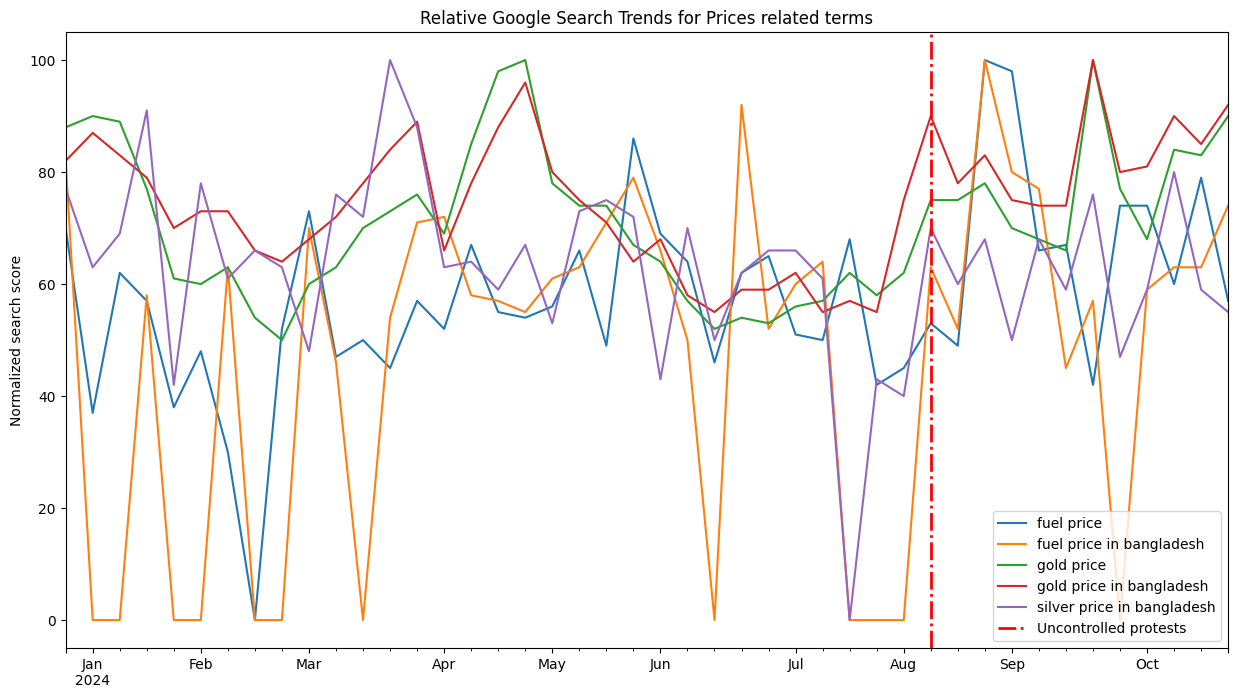

In [54]:
get_topic_charts(df, "Prices")

This graph indicates that Bangladesh experienced significant protest movements and unrest in 2024, with the public displaying a strong interest in these events through their search activity. The sharp rise in searches for "Uncontrolled protests" highlights a notable intensification of civil unrest during that period.

Other terms related to conflict, such as "quota protests" and "student protests," suggest continued political and social tensions in the country. Overall, this data offers a glimpse into the turbulent situation in Bangladesh throughout the year.

C:\Users\ronco\AppData\Local\Temp\ipykernel_18844\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


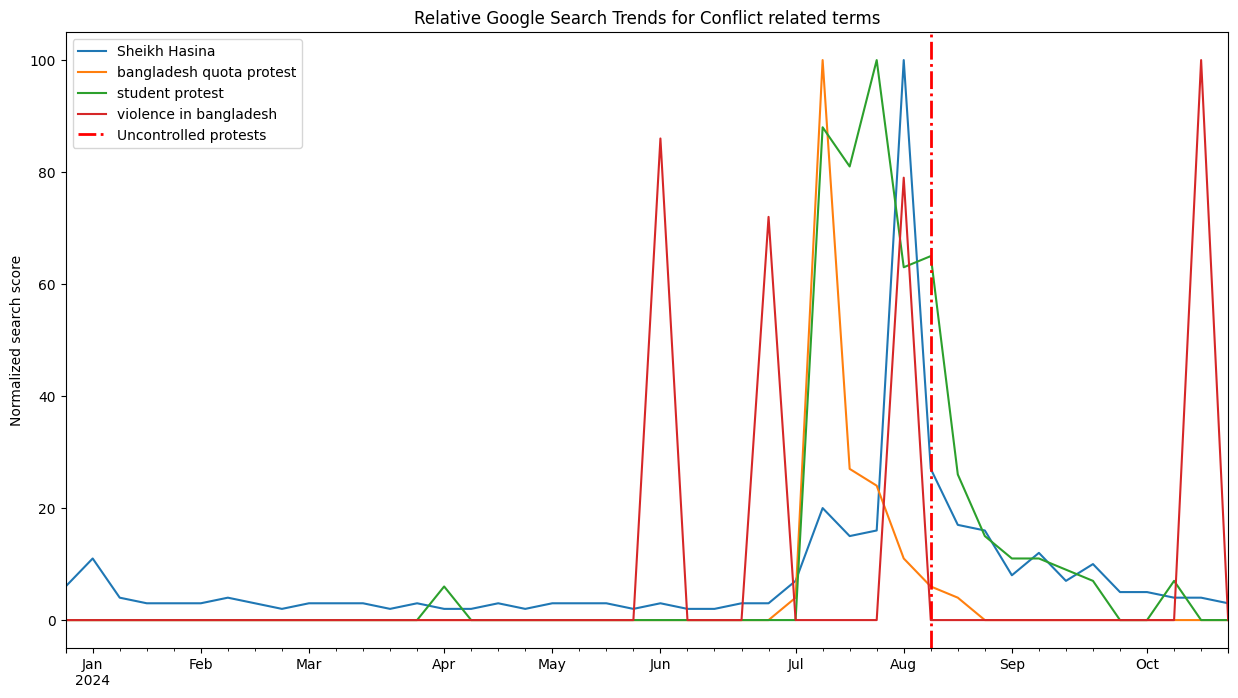

In [55]:
get_topic_charts(df, "Conflict")

The significant variations in the terms "earthquake" and "floods" suggest that Bangladesh likely faced major natural disasters associated with these events during 2024. The public seems to have been actively tracking the developments related to these incidents through their Google search patterns.

The lower search activity for "landslides" indicates that this may have been a less significant natural disaster concern for the country during the year, at least when compared to earthquakes and floods.

C:\Users\ronco\AppData\Local\Temp\ipykernel_18844\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


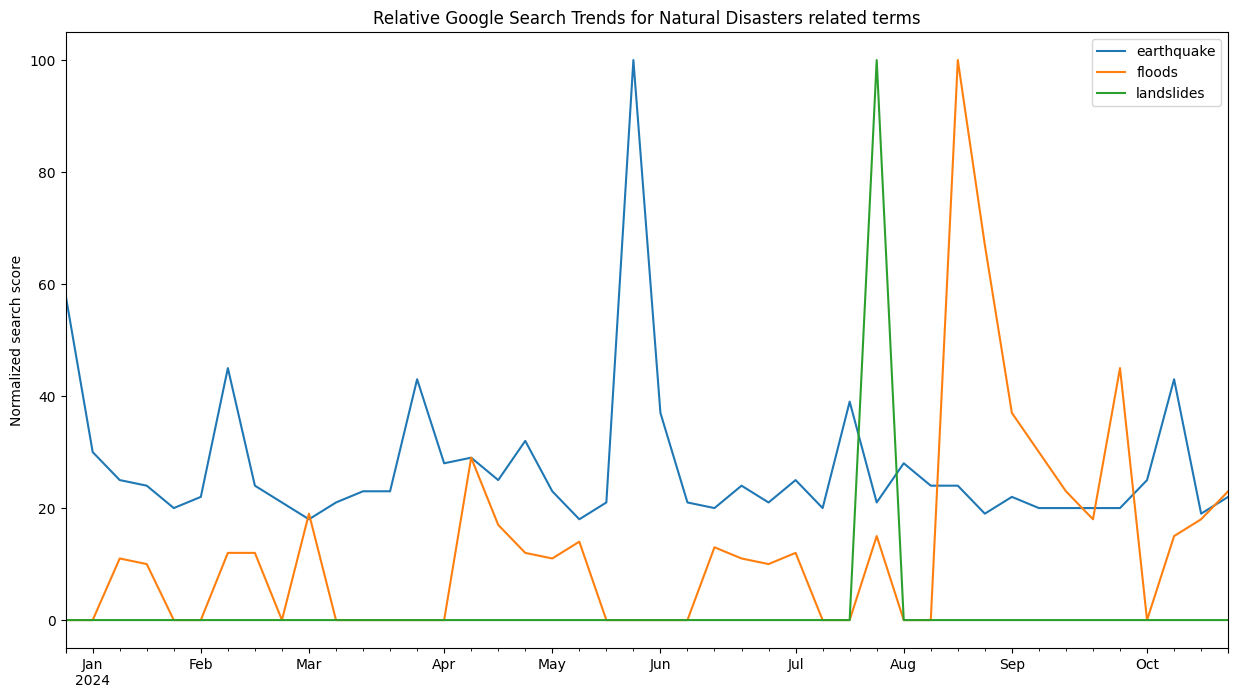

In [56]:
get_topic_charts(df, "Natural Disasters")

The variations in the "Old Dhaka" term suggest that it was probably a key element of the urban redevelopment plan, sparking considerable public interest and awareness. The surge in searches for "Uncontrolled protests" during the same period may indicate public dissatisfaction or opposition to certain aspects of the redevelopment plan.

In general, this graph offers valuable insight into the public’s focus and response to the urban redevelopment project, particularly concerning the Old Dhaka area. The data implies that notable developments or controversies surrounding this plan attracted significant attention throughout 2024.

C:\Users\ronco\AppData\Local\Temp\ipykernel_18844\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


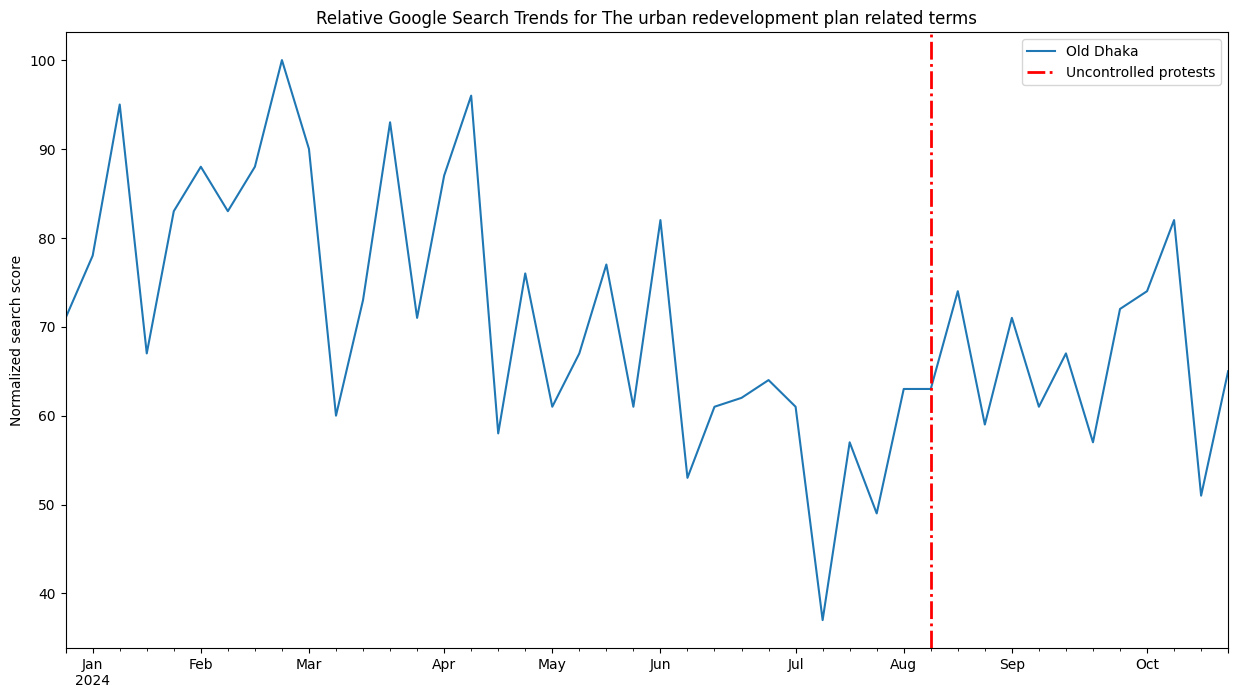

In [57]:
get_topic_charts(df, "The urban redevelopment plan")

## Subanational Coverage

Now, we analyse and visualise sub-national coverage of Google Trends search terms related to economic, social and political issues within Ethiopia's regions. It uses geographic data to represent the results on a map, highlighting the search frequency of specific terms in different regions of the country.

In [58]:
import geopandas as gpd
import pandas as pd

shapefile_path = "C:/Users/ronco/Desktop/Asistente de Investigacion/bgd_adm_bbs_20201113_SHP/bgd_admbnda_adm1_bbs_20201113.shp"

gpf = gpd.read_file(shapefile_path)

gpf

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,25.424604,0.889395,Barisal,BD10,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((90.47753 21.76919, 90.4764 21...."
1,30.287321,2.737796,Chittagong,BD20,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((92.32719 20.63543, 92.32749 20..."
2,12.197758,1.806506,Dhaka,BD30,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((90.45673 23.00396, 90.45631 23..."
3,38.409385,1.826575,Khulna,BD40,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((89.24623 21.68914, 89.2484 21...."
4,8.166577,0.941812,Mymensingh,BD45,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"POLYGON ((89.76844 25.43233, 89.76857 25.43221..."
5,8.410221,1.624856,Rajshahi,BD50,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"POLYGON ((89.02818 25.27743, 89.02833 25.27742..."
6,15.369683,1.465681,Rangpur,BD55,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((89.51742 26.0265, 89.51753 26...."
7,9.800293,1.103963,Sylhet,BD60,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((91.30353 23.99673, 91.30344 23..."


In [59]:
gpf['ADM1_PCODE']

0    BD10
1    BD20
2    BD30
3    BD40
4    BD45
5    BD50
6    BD55
7    BD60
Name: ADM1_PCODE, dtype: object

In [60]:
print(gpf['ADM1_PCODE'].isnull().sum())

0


In [61]:
gpf['ADM1_PCODE'] = gpf['ADM1_PCODE'].str.strip() 
gpf['ADM1_PCODE'] = gpf['ADM1_PCODE'].str.replace('\u200b', '')

print(gpf['ADM1_PCODE'].unique())

['BD10' 'BD20' 'BD30' 'BD40' 'BD45' 'BD50' 'BD55' 'BD60']


In [62]:
pcode_mapping = {
    'BD10': 'BD-A',  # Barisal
    'BD20': 'BD-B',  # Chittagong
    'BD30': 'BD-C',  # Dhaka
    'BD40': 'BD-D',  # Khulna
    'BD45': 'BD-H',  # Mymensingh
    'BD50': 'BD-E',  # Rajshahi
    'BD55': 'BD-F',  # Rangpur
    'BD60': 'BD-G'   # Sylhet
}

gpf['ADM1_PCODE'] = gpf['ADM1_PCODE'].map(pcode_mapping)
gpf

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,25.424604,0.889395,Barisal,BD-A,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((90.47753 21.76919, 90.4764 21...."
1,30.287321,2.737796,Chittagong,BD-B,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((92.32719 20.63543, 92.32749 20..."
2,12.197758,1.806506,Dhaka,BD-C,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((90.45673 23.00396, 90.45631 23..."
3,38.409385,1.826575,Khulna,BD-D,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((89.24623 21.68914, 89.2484 21...."
4,8.166577,0.941812,Mymensingh,BD-H,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"POLYGON ((89.76844 25.43233, 89.76857 25.43221..."
5,8.410221,1.624856,Rajshahi,BD-E,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"POLYGON ((89.02818 25.27743, 89.02833 25.27742..."
6,15.369683,1.465681,Rangpur,BD-F,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((89.51742 26.0265, 89.51753 26...."
7,9.800293,1.103963,Sylhet,BD-G,None,None,None,Bangladesh,BD,2015-01-01,2020-11-13,0000/00/00,"MULTIPOLYGON (((91.30353 23.99673, 91.30344 23..."


In [63]:
sub_dirs = [{'BD-A': 'Barisal'},
            {'BD-B': 'Chittagong'},
            {'BD-C': 'Dhaka'},
            {'BD-D': 'Khulna'},
            {'BD-H': 'Mymensingh'},
            {'BD-E': 'Rajshahi'},
            {'BD-F': 'Rangpur'},
            {'BD-G': 'Sylhet'}]

In [64]:
df = pd.DataFrame()
for geo in sub_dirs:
    for dicts in [forex_terms, deval_terms, price_terms, disaster_terms, conflict_terms, other_terms]:

        for topic, lis in dicts.items():
            for term in lis:
                filters = {
                            'terms': term,
                            'geoRestriction_region': list(geo.keys())[0],
                            'time_startDate': "2024-01-01",
                            #'time_endDate' : "2024-10-",
                            "timelineResolution" : "week"
                        }
                try:

                    r = google.get('getTimelinesForHealth', filters)

                    df_ = pd.DataFrame(r['lines'][0]['points'])
                    df_['term'] = term
                    df_['topic'] = topic
                    df_['geo'] = list(geo.keys())[0]

                    df = pd.concat([df, df_])

                except HttpError:
                    pass

In [65]:
gpf = gpf[gpf.ADM0_PCODE == 'BD']


con_map = {
    'Barisal': 'BD-A',
    'Chittagong': 'BD-B',
    'Dhaka': 'BD-C',
    'Khulna': 'BD-D',
    'Mymensingh': 'BD-H',
    'Rajshahi': 'BD-E',
    'Rangpur': 'BD-F',
    'Sylhet': 'BD-G'
}

gpf['ISO_S1'] = gpf.ADM1_EN.map(con_map)

In [66]:
count_temp = df[df.value != 0].groupby(['topic', 'term', 'geo'])['value'].count().reset_index()

In [67]:
count_temp

,topic,term,geo,value
0,Conflict,Sheikh Hasina,BD-A,15
1,Conflict,Sheikh Hasina,BD-B,54
2,Conflict,Sheikh Hasina,BD-C,55
3,Conflict,Sheikh Hasina,BD-D,38
4,Conflict,Sheikh Hasina,BD-E,40
...,...,...,...,...
109,The urban redevelopment plan,Old Dhaka,BD-B,3
110,The urban redevelopment plan,Old Dhaka,BD-C,54
111,The urban redevelopment plan,Old Dhaka,BD-D,1
112,The urban redevelopment plan,Old Dhaka,BD-E,2


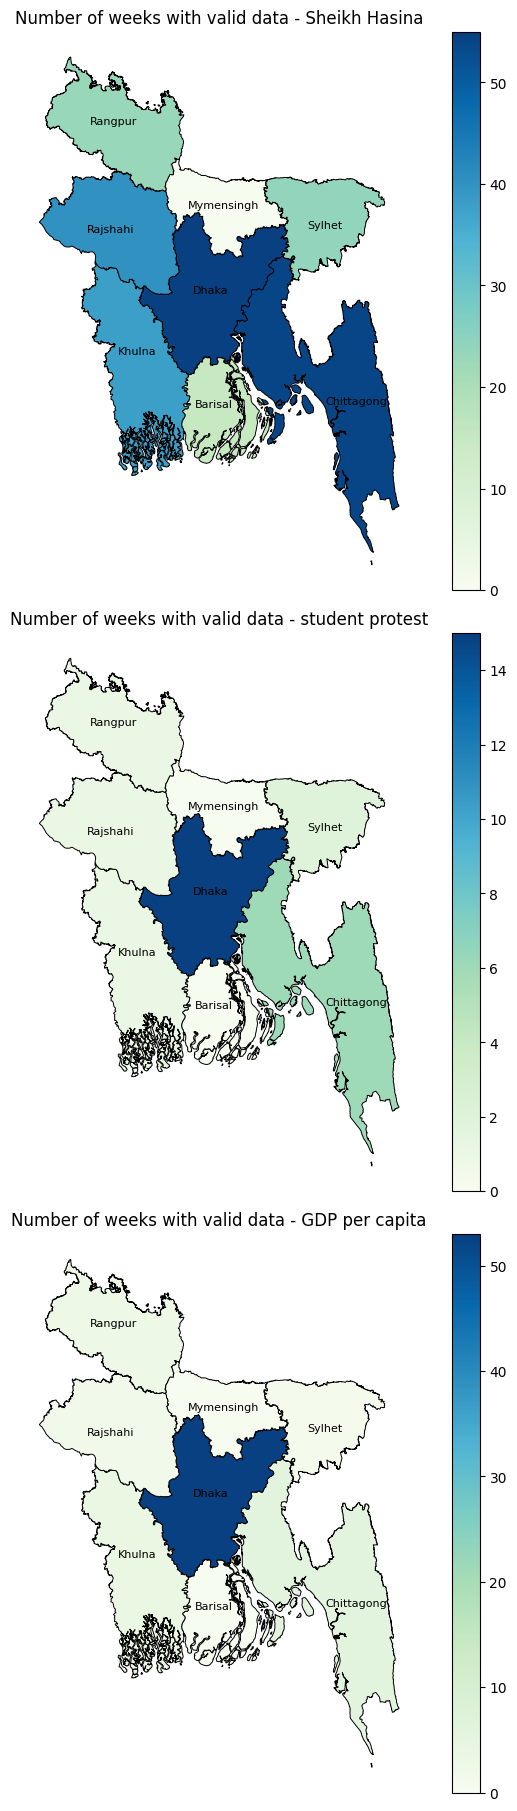

In [68]:

terms = ["Sheikh Hasina", "student protest", "GDP per capita"]


fig, axes = plt.subplots(nrows=len(terms), ncols=1, figsize=(8, len(terms) * 6), constrained_layout=True)

for ax, term in zip(axes, terms):

    sub_temp = count_temp.query(f"term == '{term}'")

    sub_temp = gpf.merge(sub_temp, left_on='ISO_S1', right_on='geo', how='left')

    sub_temp['value'] = sub_temp['value'].fillna(0)

    sub_temp = gpd.GeoDataFrame(sub_temp)

    sub_temp['coords'] = sub_temp['geometry'].apply(lambda x: x.representative_point().coords[:])
    sub_temp['coords'] = [coords[0] for coords in sub_temp['coords']]

    sub_temp.plot(column='value', cmap='GnBu', legend=True, edgecolor='k', linewidth=0.7, ax=ax)

    for idx, row in sub_temp.iterrows():
        ax.text(row.coords[0], row.coords[1], s=row['ADM1_EN'],
                horizontalalignment='center', fontsize=8, color='black')

    ax.axis('off')
    ax.set_title(f"Number of weeks with valid data - {term}", fontsize=12)

plt.show()

## Flourish of Bangladesh

This Python code aims to gather and process Google Trends data for different terms across five categories: Finance, Business, Law, Health, and Travel. Each category has specific subcategories, and within each subcategory, there are multiple search terms. The script iterates through all the terms and uses a predefined API (google.get('getGraph')) to fetch search trend data for Bangladesh within the time range from January 2024 to October 2024.

In [69]:
finance_terms = {"Finance": [{"Bank": ["bangladesh bank", "bank of bangladesh", "commercial bank",
                                       "bangladesh commercial bank", "commercial bank of bangladesh",
                                       "Sonali Bank PLC", "Janata Bank PLC","Agrani Bank PLC",
                                       "Rupali Bank PLC", "BRAC Bank PLC", "Dutch-Bangla Bank PLC",
                                       "Islami Bank Bangladesh PLC", "Standard Chartered Bank","Pubali Bank PLC",
                                       "bank rate today", "what is bank", "national bank of bangladesh",
                                       "today bank exchange rate", "bank account", "exchange rate today"
                                       ]},
                             {"Mobile banking": ["mobile banking app", "mobile banking code", "mobile banking app download",
                                                 "Sonali e-Wallet", "Janata mobile", "Islami mobile"]},
                             {"Currency": ["bangladesh currency", "currency exchange", "dollar", "dollar currency",
                                           "exchange rate", "euro currency", "foreign currency"
                                           ]}

                             ]}

business_terms = {"Business & industrial" : [{"Mining": ["what is mining", "bitcoin", "bitcoin mining", "mining in bangladesh",
                                                         "mining meaning", "crypto mining", "data mining", "gold mining", "usdt mining", "ton mining",
                                                         "cloud mining", "crypto mining app", "what is bitcoin mining", "what is data mining", "bitcoin mining app",
                                                         "what is bitcoin", "bitcoin mining free", "ton coin mining", "mining engineering", "free bitcoin mining"

                                            ]},
                                             {"Logistics": ["logistics management", "supply chain management", "logistics jobs", "what is logistics", "transport and logistics",
                                                            "logistics meaning", "ministry of transport and logistics", "inbound logistics"

                                             ]},
                                             {"Media": ["social media", "what is media", "ATN Bangla", "Prothom Alo"

                                             ]},
                                             {"Communication": ["what is communication", "communication skills", "business communication", "data communication", "effective communication", "communication english",
                                                                "communication technology", "communication media", "types of communication", "information", "communication meaning", "wireless communication", "communication process", "communication skill",
                                                                "health communication", "mobile communication", "verbal communication", "process of communication", "define communication", "type of communication",
                                                                "meaning of communication", "communication barriers", "good communication", "communication skills pdf", "business communication pdf"
                                             ]},

                                             {"Technology": ["science", "what is technology", "science and technology", "information technology", "emerging technology", "digital technology",
                                                             "new technology", "Bangladesh University of Engineering and Technology", "International University of Business Agriculture and Technology",
                                                             "ai technology", "define technology", "blockchain technology", "what is computer", "what is digital technology", "computer science",
                                                             "advantage of technology", "educational technology", "information communication technology", "ministry of innovation and technology"
                                                             ]
                                              }]}

law_terms = {"Law & Government" : [{"Ethics": ["what is ethics", "professional ethics", "morality", "business ethics", "virtue ethics", "ethics and morality",
                                               "ethics meaning", "code of ethics", "medical ethics", "health ethics", "research ethics", "work ethics",
                                               "principles of ethics", "what is the difference between", "normative ethics", "types of ethics", "ethics example",
                                               "what is ethics pdf", "define ethics", "environmental ethics", "what is morality", "applied ethics", "nursing ethics", "what is virtue ethics",
                                               "difference between ethics and morality"]},
                                   {"Rights": ["human rights", "what is rights", "human rights in bangladesh", "what is human rights", "all", "human rights law",
                                               "2024", "what are human rights", "reserved", "civil rights", "all rights reserved", "democratic rights",
                                               "copyright", "bangladeshi human rights commission", "international human rights law", " what is human right",
                                               "human rights watch", "sexual rights", "intellectual property rights", "intellectual property", "features of human rights",
                                               "examples of human rights", "importance of human rights", "universal declaration of human rights"]},
                                   {"Corporation": ["bangladeshi broadcasting corporation", "BEXIMCO Group", "Bashundhara Group", "Meghna Group of Industries", "Square Group","ACI Limited", "Pran-RFL Group",
                                                "Abul Khair Group", "City Group", "Transcom Group", "Akij Group", "T K Group of Industries","Ananda Group","Partex Group","Rahimafrooz Group","LafargeHolcim Bangladesh Limited","Grameenphone", "Robi Axiata Limited",
                                                "Summit Group", "United Group", "Olympic Industries Limited"]},
                                   {"War": ["world war", "israel", "israel war", "ukraine war", "russia war", "what is war", "war news", "russia ukraine war", "russia ukraine",
                                            "civil war", "war in bangladesh", "bangladesh war", "war movies", "god of war", "cold war", "first world war", "world war 2",
                                            "russia news", "russia war news", "Rohingya Refugee Crisis"]
                                    }]}

health_terms = {"Health" : [{"Nursing": ["nursing diagnosis", "nursing care plan", "what is nursing", "nursing process", "surgical nursing", "medical surgical nursing", "nursing questions and answers",
                                         "nursing assessment", "nanda", "nanda nursing diagnosis", "nursing research", "clinical nursing", "nursing school", "medical surgical nursing pdf", "nursing care plan pdf",
                                         "nursing intervention", "nursing home", "nursing ethics", "pediatric nursing", "nursing process pdf", "basic nursing", "nursing procedure", "what is nursing pdf"]},
                            {"Nutrition": ["nutrition food", "nutrition pdf", "what is nutrition", "nutrition jobs", "human nutrition", "nutrition security", "food science and nutrition", "nutrition ppt",
                                           "animal nutrition", "malnutrition", "nutrition international", "nutrition meaning", "loza nutrition", "milk nutrition", "avocado nutrition", "banana nutrition",
                                           "ethio fitness and nutrition", "maternal and child nutrition", "oats nutrition", "health and nutrition", "nutrition officer", "community nutrition", "nutrition exam",
                                           "oats", "types of nutrition", "peanut", "beans nutrition", "potato nutrition"]},
                            {"Skin": ["what is skin", "dry skin", "skin care", "skin disease", "skin infection", "cerave", "acne", "skin rash", "moisturizer", "skin type",
                                      "skin cancer", "sensitive skin", "itchy skin", "skin allergy", "sunscreen for oily skin", "types of skin", "skin tone", "skin itching",
                                      "skin diseases", "cerave for oily skin", "cerave cleanser", "vitamin c", "vitamin e" ]
                             }]}

travel_terms = {"Travel": [{"Airline": ["bangladeshi airline", "bangladesh airline", "bangladesh vacancy", "bangladesh airline result", "bangladesh airline vacancy", "airline booking", "bangladesh airline phone number",
                                        "bangladeshi airlines ticket", "bangladesh airline ticket", "airline tickets", "bangladeshi airline booking", "bangladeshi airline vacancy result", "indian airline", "indian airline app"]},
                           {"Airport": ["Hazrat Shahjalal International Airport","Shah Amanat International Airport", "Osmani International Airport", "Cox's Bazar Airport", "Jessore Airport", "Saidpur Airport", "Barisal Airport",
                                        "airport ticket", "indian airport", "airport vacancy"]},
                           {"Flight": ["bangladeshi flight", "airlines", "bangladeshi airlines flight", "flight status", "flight ticket", "flight tracker", "flight radar", "bangladeshi airlines flight schedule", "booking flight",
                                       "flight booking", "google flight", "bangladeshi airlines ticket", "book flight", "flight check", "flight radar 24", "cheap flight", "bangladeshi airlines ticket price" , "bangladeshi airlines flight booking"]},
                           {"Driving": ["driving license", "car driving", "driving license", "driving test", "driving license in bangladesh", "car games", "car driving games", "international driving license", "manual car driving",
                                        "driving license test", "driving license check online", "city car driving", "check driving license number online", "car driving training"]},
                           {"Hotels": ["Pan Pacific Sonargaon Dhaka", "The Westin Dhaka", "Radisson Blu Dhaka Water Garden","InterContinental Dhaka", "Le Méridien Dhaka","Six Seasons Hotel","Hotel Sarina Dhaka","Amari Dhaka","Sayeman Beach Resort",
                                        "Dusai Resort & Spa", "best hotels in dhaka", "hotels in dhaka", "booking", "cheap hotels in dhaka"]
                            }]}

In [70]:
df = pd.DataFrame()


for dicts in [finance_terms, business_terms, law_terms, health_terms, travel_terms]:
    for category, subcategories in dicts.items():
        for subcategory_dict in subcategories:
            for subcategory, terms in subcategory_dict.items():
                for term in terms:
                    filters = {
                        'terms': term,
                        'restrictions_geo': "BD",  
                        'restrictions_startDate': "2024-01",  
                        'restrictions_endDate': "2024-10"  
                    }

                    try:
                        result = google.get('getGraph', filters)

                        value = sum(point['value'] for point in result['lines'][0]['points']) / len(result['lines'][0]['points'])

                        df = pd.concat(
                            [df, pd.DataFrame({
                                'Category': [category],
                                'Subcategory': [subcategory],
                                'Term': [term],
                                'Value': [value]
                            })],
                            ignore_index=True
                        )

                        print(f"Datos obtenidos para {term} en {subcategory}.")
                    except Exception as e:
                        print(f"Error al procesar {term} en {subcategory}: {e}")

print(df.head())

Datos obtenidos para bangladesh bank en Bank.
Datos obtenidos para bank of bangladesh en Bank.
Datos obtenidos para commercial bank en Bank.
Datos obtenidos para bangladesh commercial bank en Bank.
Datos obtenidos para commercial bank of bangladesh en Bank.
Datos obtenidos para Sonali Bank PLC en Bank.
Datos obtenidos para Janata Bank PLC en Bank.
Datos obtenidos para Agrani Bank PLC en Bank.
Datos obtenidos para Rupali Bank PLC en Bank.
Datos obtenidos para BRAC Bank PLC en Bank.
Datos obtenidos para Dutch-Bangla Bank PLC en Bank.
Datos obtenidos para Islami Bank Bangladesh PLC en Bank.
Datos obtenidos para Standard Chartered Bank en Bank.
Datos obtenidos para Pubali Bank PLC en Bank.
Datos obtenidos para bank rate today en Bank.
Datos obtenidos para what is bank en Bank.
Datos obtenidos para national bank of bangladesh en Bank.
Datos obtenidos para today bank exchange rate en Bank.
Datos obtenidos para bank account en Bank.
Datos obtenidos para exchange rate today en Bank.
Datos obte

Finally, we visualizes the hierarchical relationship between different categories, subcategories, and terms, with their corresponding values, in an interactive and visually appealing way. The chart helps to explore trends and patterns in the data for Bangladesh.

In [71]:
import plotly.express as px

fig = px.sunburst(
    df,
    path=['Category', 'Subcategory', 'Term'],  
    values='Value',  
    color='Category',  
    title='Flourish interactive of Bangladesh'
)

fig.update_layout(
    width=800,  
    height=600  
)

fig.show()